In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import math

In [14]:
"""
Helper functions
"""

def DEVSTimeToMinutes(aDEVSTime):
    """Converts a DEVS Timestamp into minutes."""
    START_YEAR = 1990
    
    splittedDate = aDEVSTime.split(':')
    # Normal assert
    hours = int(splittedDate[0])
    minutes = int(splittedDate[1])
    seconds = int(splittedDate[2])
    mseconds = int(splittedDate[3])
    
    return minutes + hours * 60

def format_date(x, pos=None):
    """Formats a minutes value into DEVS Time format."""
    hours = math.floor(x / 60)
    minutes = x - hours*60
    
    return '%02d:%02d:00:00' % (hours,minutes)

def daysToHours(someDays):
    """Converts days to hours."""
    return someDays * 24 * 60

## Assumptions

It is assumed the the output being parsed was generated with the following top model: **models/controllerAndSolar.ma**. This contains three output ports:
- **grid_out**: Power demanded on sold to the grid. 
- **controlBatteryState**: Battery state changes.
- **controlBatteryDemand**: Power demanded from the controller to the battery.

In [3]:
outputFile = open('../simulation/src/out/solarAndWind1Week', 'r')

parsedOutput = []
for line in outputFile:
    # Trim newline character from read line
    line = line[:-1]
    # Split by spaces
    splittedLine = line.split(' ')
    # Drop excedent emoty read par`bts
    splittedLine = [readPart for readPart in splittedLine if readPart != '']
    parsedOutput.append(splittedLine)

In [4]:
parsedData = pd.DataFrame(data=parsedOutput, columns=['time', 'port', 'value'])
parsedData.loc[:, 'value'] = parsedData.value.astype(float)
parsedData.loc[:, 'time'] = parsedData.time.map(DEVSTimeToMinutes)

In [5]:
parsedData.columns

Index(['time', 'port', 'value'], dtype='object')

In [6]:
parsedData.port.unique()

array(['solarpowerbeinggenerated', 'windpowerbeinggenerated', 'grid_out',
       'controlbatterystate', 'controlbatterydemand', 'grid_sell'],
      dtype=object)

In [7]:
gridOutData = parsedData[parsedData.port == 'grid_out']
gridSellData = parsedData[parsedData.port == 'grid_sell']
generatedSolarPower = parsedData[parsedData.port == 'solarpowerbeinggenerated']
generatedWindPower = parsedData[parsedData.port == 'windpowerbeinggenerated']
batteryDemand = parsedData[parsedData.port == 'controlbatterydemand']
batteryState = parsedData[parsedData.port == 'controlbatterystate']

### Qué generador vale más?

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))

ax.plot(generatedSolarPower.time, generatedSolarPower.value, color='y', label='Potencia generada energía solar')

ax.set_xlim(left=0)

ax.set_xlabel('Tiempo [DEVS time]')
ax.set_ylabel('Potencia instantánea generada [W]')

ax.legend()


ax[1].set_xlim(left=0)
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[1].set_xticks(np.arange(daysToHours(1),daysToHours(SIMULATION_DAYS), daysToHours(1)))

ax[1].legend()

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

### Plotting update in battery charge

In [8]:
columnMappers = {
    'time': DEVSTimeToMinutes,
    'charge': float
}
chargeChanges = pd.read_csv('../simulation/src/out/batteryChargeChanges_solarAndWind1Week',\
            sep=';', usecols=[1,2], names=['time', 'charge'], converters=columnMappers)

### Outline de la experimentación
- Explicar mas o menos como son los pasos, el ambiente de experimentación, las fuentes de datos y una descripción cauntitativa de la misma.
- Explicar datos de la batería + generadores. Quizas describir en la parte del modelo las ecuaciones que los dominan.
- Mostrar resultados para modelo solo con generación solar.
- Mostrar para solar + eolica.
- Concluir que la que va es solar + eólica.

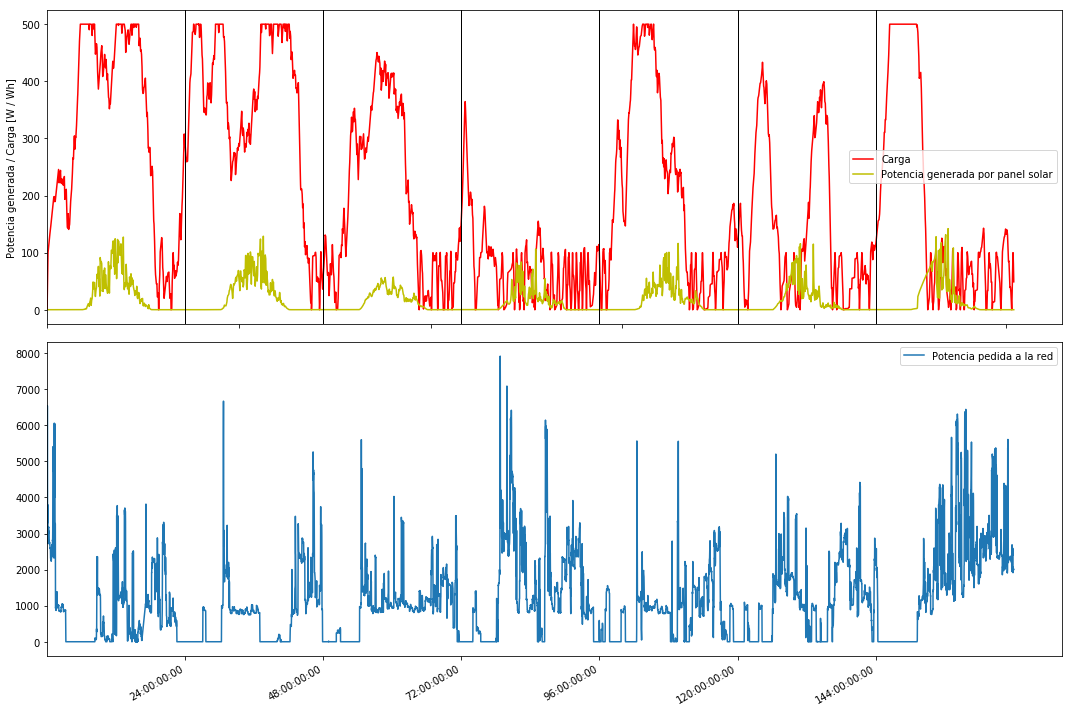

In [9]:
# TODO: Mover los plot potencia generada, a una que tenga la generada solar y eolica. De esta manera, se puede comparar la evolución de la carga, con la
# generación de ese dia y su distribución, y la demanda.

SIMULATION_DAYS = 7
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (15,10))

ax[0].plot(chargeChanges.time, chargeChanges.charge, color='r', label='Carga')
ax[0].plot(generatedSolarPower.time, generatedSolarPower.value, color='y', label='Potencia generada por panel solar')

ax[0].set_xlim(left=0)

ax[0].set_xlabel('Tiempo [DEVS time]')
ax[0].set_ylabel('Potencia generada / Carga [W / Wh]')

ax[0].legend()

for day in range(SIMULATION_DAYS-1):
    ax[0].axvline(x=24*60*(day+1), color='black', linewidth=1)

ax[1].plot(gridOutData.time, gridOutData.value, label='Potencia pedida a la red')

ax[1].set_xlim(left=0)
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[1].set_xticks(np.arange(daysToHours(1),daysToHours(SIMULATION_DAYS), daysToHours(1)))

ax[1].legend()

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

### Battery state changes according to charge

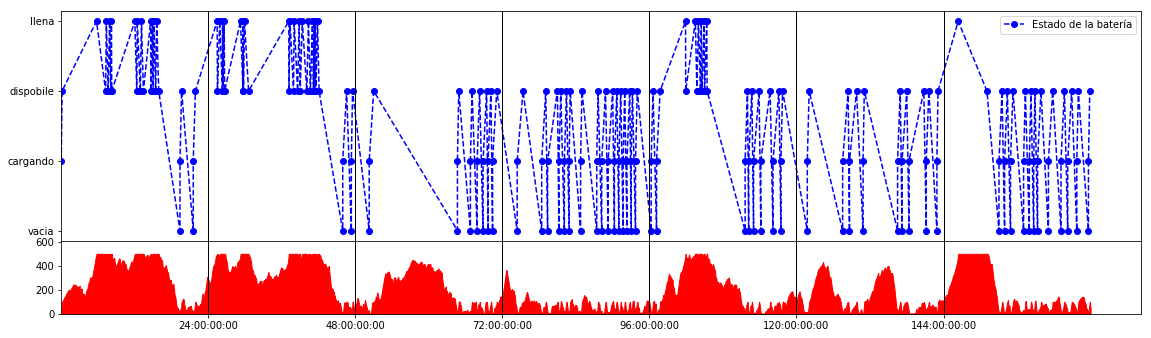

In [12]:
SIMULATION_DAYS = 7
fig, ax = plt.subplots(nrows=2, sharex=True, figsize = (15,10))

ax[0].plot(batteryState.time, batteryState.value, '--bo', label='Estado de la batería')

for day in range(SIMULATION_DAYS-1):
    ax[0].axvline(x=24*60*(day+1), color='black', linewidth=1)
    ax[1].axvline(x=24*60*(day+1), color='black', linewidth=1)

ax[0].set_xlim(left=0)
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[0].set_position(matplotlib.transforms.Bbox.from_bounds(0,0,1,.32))
ax[0].set_xticks(np.arange(daysToHours(1),daysToHours(SIMULATION_DAYS), daysToHours(1)))

ax[0].set_yticks([0,1,2,3])
yAxisMap = {
    0: 'vacia',
    1: 'cargando',
    2: 'dispobile',
    3: 'llena'
}

ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda aValue, tickPos: yAxisMap[aValue]))

ax[0].legend()

# set the position of ax2 so that it is short (y2=0.32) but otherwise the same size as ax
ax[1].set_position(matplotlib.transforms.Bbox.from_bounds(0,-.101,1,.10))
ax[1].fill_between(chargeChanges.time, chargeChanges.charge, color='r', label='Carga')
ax[1].spines['top'].set_visible(False)
ax[1].yaxis.set_visible(True)
ax[1].set_ylim(bottom=0,top=600)


# plt.tight_layout()
plt.ion()
plt.show()

### Analizing enery sold to the grid

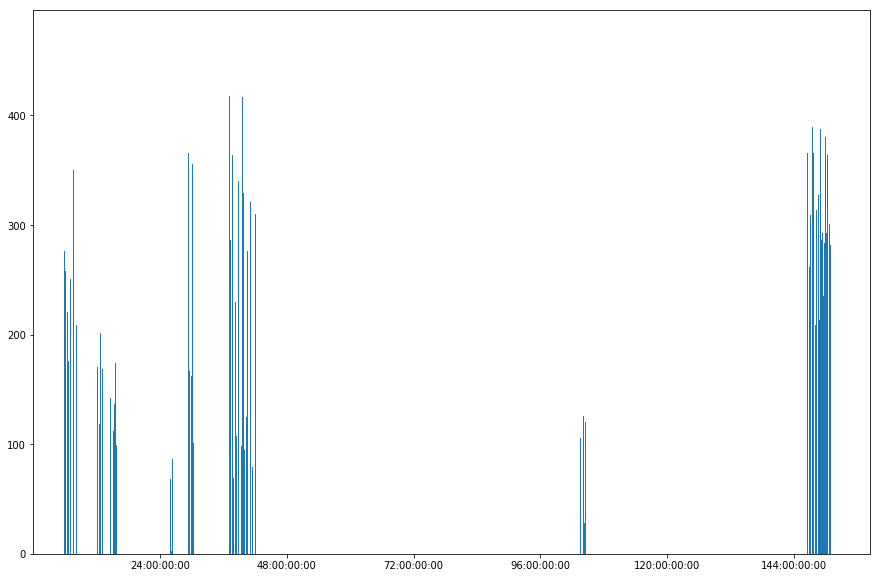

In [11]:
fig, ax = plt.subplots(figsize = (15,10))

ax.bar(gridSellData.time, gridSellData.value)

ax.set_xlim(left=0)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.set_xticks(np.arange(daysToHours(1),daysToHours(SIMULATION_DAYS), daysToHours(1)))

plt.show()